<a href="https://colab.research.google.com/github/mystlee/2024_CSU_AI/blob/main/chapter5/torch_Unet_example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 0. 모델 구성, 학습 등을 위한 라이브러리 import   
### torch   
  - pytorch 프레임워크   

### torch.nn
  - nn = neural network   
  - 딥러닝 관련 라이브러리  
  - fully-connected layer, conv layer 등을 포함  

### torchvision   
  - torch에서 제공하는 image 처리 특화 라이브러리

### torch.optim
  - 모델 학습을 위한 옵티마이저 라이브러리   
  - SGD, AdaGrad, RMSProp, Adam 등 옵티마이저 포함

### torch.utils.data
  - torch에서 제공하는 dataset 다운로드 및 관리 패키지   



In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset


## 1. 데이터셋 구성   
MNIST 데이터를 load 한 뒤, noise 추가   
data loader로 변환   

In [ ]:
batch_size = 64

class AddGaussianNoise(object):
    def __init__(self, mean = 0., std = 0.1):
        self.std = std
        self.mean = mean

    def __call__(self, tensor):
        return tensor + torch.randn_like(tensor) * self.std + self.mean

class NoisyMNISTDataset(Dataset):
    def __init__(self, train=True):
        self.mnist = datasets.MNIST(root = './data',
                                    train = train,
                                    download = True,
                                    transform = transforms.ToTensor())
        self.noise_transform = AddGaussianNoise(0., 0.1)

    def __len__(self):
        return len(self.mnist)

    def __getitem__(self, idx):
        img, _ = self.mnist[idx]
        noisy_img = self.noise_transform(img)
        return noisy_img, img

train_dataset = NoisyMNISTDataset(train = True)
train_loader = DataLoader(train_dataset,
                          batch_size = batch_size,
                          shuffle = True)

test_dataset = NoisyMNISTDataset(train = False)
test_loader = DataLoader(test_dataset,
                         batch_size = batch_size,
                         shuffle = False)


## 2. 모델 구조   
### 모델 구조 작성   
- 일반적으로 class 의 \_\_init\_\_ 함수부분에서 모듈들은 선언하고,
- 그 다음 forward 함수에 전체적인 흐름 작성   
- Encoder-decoder 구조로 가장 popular하게 쓰이는 구조
- nn.sequential은 layer를 하나의 block으로 묶는 역할# 2. 모델 구조   
### 모델 구조 작성   
- 일반적으로 class 의 \_\_init\_\_ 함수부분에서 모듈들은 선언하고,
- 그 다음 forward 함수에 전체적인 흐름 작성   
- Encoder-decoder 구조로 가장 popular하게 쓰이는 구조
- nn.sequential은 layer를 하나의 block으로 묶는 역할

<img src = "https://miro.medium.com/v2/resize:fit:1400/1*qNdglJ1ORP3Gq77MmBLhHQ.png" width = "80%" height = "70%">   

출처: <https://medium.com/@msmapark2/u-net-%EB%85%BC%EB%AC%B8-%EB%A6%AC%EB%B7%B0-u-net-convolutional-networks-for-biomedical-image-segmentation-456d6901b28a>   

In [4]:
class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()

        # Encoder 구성
        self.enc_conv1 = nn.Sequential(
            nn.Conv2d(1, 64, 3, padding=1),
            nn.ReLU()
        )
        self.enc_conv2 = nn.Sequential(
            nn.Conv2d(64, 128, 3, padding=1),
            nn.ReLU()
        )
        self.pool = nn.MaxPool2d(2)

        # Decoder 구성
        self.up_sample = nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.dec_conv1 = nn.Sequential(
            nn.Conv2d(128, 64, 3, padding=1),
            nn.ReLU()
        )
        self.dec_conv2 = nn.Conv2d(64, 1, 1)

    def forward(self, x):
        # Encoder
        x1 = self.enc_conv1(x)
        x2 = self.pool(x1)
        x3 = self.enc_conv2(x2)

        # Decoder
        x4 = self.up_sample(x3)
        x = torch.cat([x1, x4], dim = 1)  # Skip connection
        x = self.dec_conv1(x)
        x = self.dec_conv2(x)
        return x


## 3. 손실 함수 및 옵티마이저 정의 및 학습
- batch 단위로 update 진행
- error와 gradients를 계산하고 업데이트!
- regression task -> MSE loss를 사용!
- optimizer는 Adam 사용
- 학습 함수는 간단하여 별도 함수를 작성하지 않음



In [7]:
num_epochs = 5

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = UNet().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr = 0.001)

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for noisy_imgs, clean_imgs in train_loader:
        noisy_imgs = noisy_imgs.to(device)
        clean_imgs = clean_imgs.to(device)

        optimizer.zero_grad()
        outputs = model(noisy_imgs)
        loss = criterion(outputs, clean_imgs)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    avg_loss = running_loss / len(train_loader)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}')


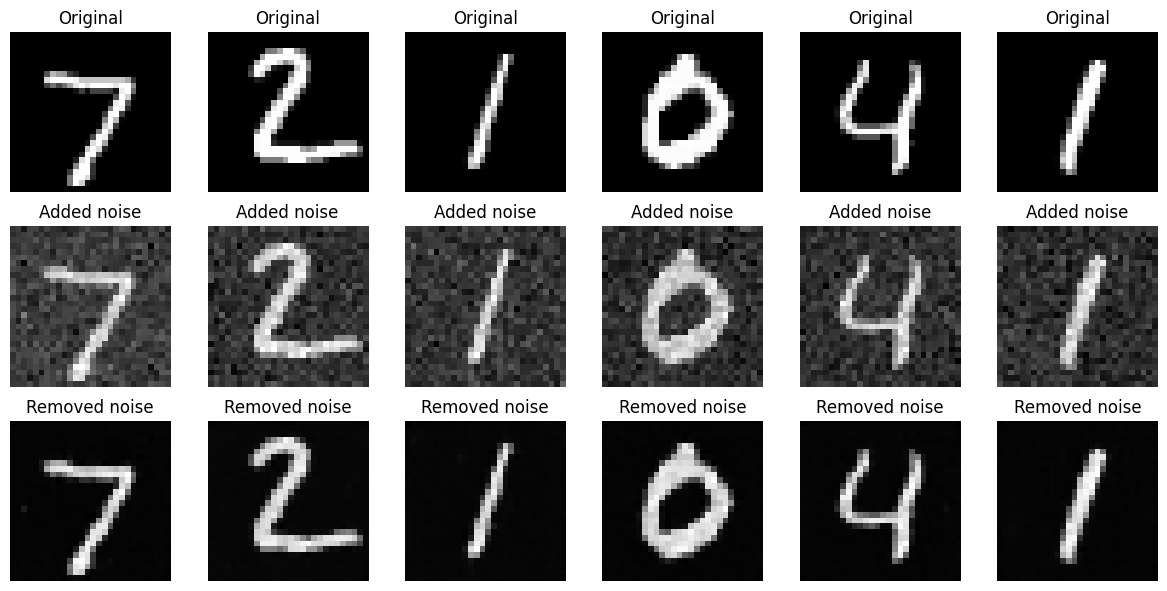

In [10]:
import matplotlib.pyplot as plt

model.eval()
with torch.no_grad():
    for noisy_imgs, clean_imgs in test_loader:
        noisy_imgs = noisy_imgs.to(device)
        outputs = model(noisy_imgs)
        break  # 첫 번째 batch에서 데이터 취득

# 시각화를 위해 CPU로 이동
noisy_imgs = noisy_imgs.cpu()
outputs = outputs.cpu()
clean_imgs = clean_imgs.cpu()

fig, axes = plt.subplots(nrows=3, ncols=6, figsize=(12, 6))
for i in range(6):
    axes[0, i].imshow(clean_imgs[i].squeeze(), cmap = 'gray')
    axes[0, i].set_title('Original')
    axes[0, i].axis('off')

    axes[1, i].imshow(noisy_imgs[i].squeeze(), cmap = 'gray')
    axes[1, i].set_title('Added noise')
    axes[1, i].axis('off')

    axes[2, i].imshow(outputs[i].squeeze(), cmap = 'gray')
    axes[2, i].set_title('Removed noise')
    axes[2, i].axis('off')

plt.tight_layout()
plt.show()
